In [1]:
%config Completer.use_jedi=False
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
from importlib import reload


#import lnPi.old
import lnPi
import lnPi.stability
import lnPi.monoutils

import lnPi2

from joblib import Parallel, delayed
from joblib.externals.loky import set_loky_pickler
import joblib


#function to tag 'LD' and 'HD' phases
def tag_phases2(x):
    if len(x) > 2:
        raise ValueError('bad tag function')
    argmax0 = np.array([xx.local_argmax()[0] for xx in x])
    return np.where(argmax0 <= x[0].shape[0] / 2, 0, 1)


# test

In [2]:
#x = np.array([0]*10 + [10] + [0]*10 + [10]  + [0]*10).astype(np.float)
#x = np.array([0]*10 + [10] + [0]*10 + [0]  + [0]*10).astype(np.float)
x = np.linspace(0, 10, 20)

r = lnPi.MaskedlnPi(x, mask=False, lnz=0.0)
p = lnPi.segment.PhaseCreator(nmax=2, ref=r, tag_phases=tag_phases2)
b = p.build_phases_mu([None])

In [3]:
c = lnPi.CollectionPhases.from_builder(np.linspace(-10, 10, 500), b)

# general look in

In [4]:
r = lnPi.MaskedlnPi(np.random.rand(20,20,20) * 10, lnz=np.random.rand(3))
p = lnPi.segment.PhaseCreator(nmax=1, ref=r)

p.build_phases([0.1, 0.2, 0.3])

b = p.build_phases_mu([None, 0.2, 0.3])
b(0.5).lnz


array([0.5, 0.2, 0.3])

In [7]:
b = p.build_phases_dmu([None, 0.5, 1.0])
b(20.0).xgce.lnz.pipe(lambda x: x - x.sel(component=0))

<xarray.DataArray 'lnz' (phase: 1, component: 3)>
array([[0. , 0.5, 1. ]])
Coordinates:
    lnz_0    float64 20.0
    lnz_1    float64 20.5
    lnz_2    float64 21.0
  * phase    (phase) int64 0
Dimensions without coordinates: component

In [5]:
c = lnPi.CollectionPhases.from_builder(np.linspace(-2, 0.0), build_phases=p.build_phases_dmu([None, 1.0, 2.0]))

# create a reference lnPi_phases for bulk case

In [273]:
pe = pd.read_csv('./PiofN/ljsf.t070.bulk.v729.r1.energy.dat', header=None, sep='\s+', names=['n','e'])['e'].values

mu = -8.616
volume = 729
temp = 0.7
beta = 1.0 / temp
state_kws = dict(volume=volume, temp=temp, beta=1/temp)
lnz = beta * mu


# reference masked lnPi
ref = lnPi.core.MaskedlnPi.from_table('./PiofN/ljsf.t070.bulk.v729.r1.lnpi.dat',fill_value=np.nan,
                                      lnz=lnz, state_kws=state_kws, extra_kws={'PE':pe}).zeromax()

# Phase Creator
PhaseCreator = lnPi.segment.PhaseCreator(nmax=2, tag_phases=tag_phases2, nmax_peak=4, merge_kws=dict(efac=0.8), 
                                         ref=ref)
build_phases = PhaseCreator.build_phases_mu([None])

In [274]:
# create a phase object
p = PhaseCreator.build_phases()
p.xgce.betaOmega()

<xarray.DataArray 'betaOmega' (phase: 2)>
array([ -2.554284, -20.713516])
Coordinates:
    lnz_0    float64 -12.31
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
  * phase    (phase) int64 0 1
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'volume', 'temp', 'beta']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

In [275]:
# old
# reference masked lnPi
ref0 = lnPi2.core.MaskedlnPi.from_table('./PiofN/ljsf.t070.bulk.v729.r1.lnpi.dat', 
                                      mu=mu, state_kws=state_kws, extra_kws={'pe':pe}).zeromax()

# Phase Creator
PhaseCreator0 = lnPi2.segment.PhaseCreator(nmax=2, tag_phases=tag_phases2, nmax_peak=4, merge_kws=dict(efac=0.8), 
                                         ref=ref0)
build_phases0 = PhaseCreator0.build_phases

p0 = PhaseCreator0.build_phases()
p0.xgce.omega().pipe(lambda x: x*x.beta)

<xarray.DataArray (phase: 2)>
array([ -2.554284, -20.713516])
Coordinates:
    mu_0     float64 -8.616
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
  * phase    (phase) int64 0 1

## create a collection

In [276]:
from joblib import Parallel, delayed
from joblib.externals.loky import set_loky_pickler
import joblib

set_loky_pickler('pickle')

In [277]:
lnzs = np.linspace(ref.lnz[0] - 5, ref.lnz[0] + 5, 600)
#lnzs = np.geomspace(ref.lnz[0] - 5, ref.lnz[0] + 5, 500)
mus = lnzs / beta

In [278]:
%%timeit -n 1 -r 1
with lnPi.set_options(tqdm_leave=True, joblib_use=True):
    c = lnPi.CollectionPhases.from_builder(lnzs, build_phases=build_phases)


610 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [8]:
%%timeit -n 1 -r 1
with lnPi.set_options(tqdm_leave=True, joblib_use=False):
    c = lnPi.CollectionPhases.from_builder(lnzs, build_phases=build_phases)


642 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [358]:
with lnPi.set_options(tqdm_leave=True, joblib_use=True):
    c = lnPi.CollectionPhases.from_builder(lnzs[:], build_phases=build_phases)

In [345]:
def func(x):
    return x

def func_attr(x, attr):
    return getattr(x, attr)

def func_call(x, *args, **kwargs):
    return x(*args, **kwargs)

In [334]:
%%timeit -n 1 -r 1 

with lnPi.set_options(tqdm_leave=True):
    c.xgce.nvec


2.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [382]:
with lnPi.set_options(tqdm_leave=True, joblib_use=True):
    c = lnPi.CollectionPhases.from_builder(lnzs[:], build_phases=build_phases)
L = []
Index = []
for i, x in enumerate(c):
    name = x.index.name
    for item, index in zip(x.items, x.index):
        item._optinfo['state_kws'] = dict(item._optinfo['state_kws'], **{name : index, 'sample':i})
        L.append(item)
#     L += x.items
#     index.extend([(i, idx) for idx in x.index])

C =lnPi.CollectionPhases(L)

In [339]:
%%timeit -n 1 -r 1
with lnPi.set_options(tqdm_leave=True):
    C.xgce.nvec.set_index({'rec':['sample','phase']}).unstack('rec')


2.18 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [381]:
%%timeit -n 1 -r 1
o = [x.nvec for x in c.xgce.items]

2.47 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [383]:
%%timeit -n 1 -r 1
o = [x.nvec for x in C.xgce.items]

1.63 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [363]:
%%timeit -n 1 -r 1
o = Parallel(1, backend='multiprocessing')(delayed(func_attr)(x, 'nvec') for x in C.xgce.items)

1.64 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [365]:
%%timeit -n 1 -r 1
o = Parallel(-1, backend='multiprocessing')(delayed(func_attr)(x, 'nvec') for x in C.xgce.items)

968 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [379]:
%%timeit -n 1 -r 1
o = Parallel(1, backend='multiprocessing')(delayed(func_call)(x.betaOmega) for x in C.xgce.items)

1.6 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [377]:
%%timeit -n 1 -r 1
o = Parallel(-1, backend='multiprocessing')(delayed(func_call)(x.betaOmega) for x in C.xgce.items)

820 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [375]:
c.xgce.betaOmega()

<xarray.DataArray 'betaOmega' (rec: 600, phase: 2)>
array([[-1.665988e-02,           nan],
       [-1.694040e-02,           nan],
       [-1.722564e-02,           nan],
       ...,
       [          nan, -3.223278e+03],
       [          nan, -3.234294e+03],
       [          nan, -3.245311e+03]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -17.31 -17.29 -17.28 -17.26 ... -7.342 -7.325 -7.309
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
    sample   (rec) int64 0 1 2 3 4 5 6 7 8 ... 592 593 594 595 596 597 598 599
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 ... 592 593 594 595 596 597 598 599
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'volume', 'temp', 'beta', 'phase', 'sample']
 

In [372]:
xr.concat(o, 'rec').set_index({'rec':['sample','phase']}).unstack('rec')

<xarray.DataArray 'nvec' (component: 1, sample: 600, phase: 2)>
array([[[1.666337e-02,          nan],
        [1.694401e-02,          nan],
        ...,
        [         nan, 6.598969e+02],
        [         nan, 6.598988e+02]]])
Coordinates:
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
    lnz_0    (sample, phase) float64 -17.31 nan -17.29 nan ... -7.325 nan -7.309
  * sample   (sample) int64 0 1 2 3 4 5 6 7 ... 592 593 594 595 596 597 598 599
  * phase    (phase) int64 0 1
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta', 'phase', 'sample']
    long_name:   ${\bf n}(\mu,V,T)$

In [163]:
o = Parallel(1, backend='multiprocessing')(delayed(func_call)(x.betaOmega) for i,x in enumerate(c.xgce.items))

In [176]:
len(c)

600

In [180]:
for x in c:
    x.xgce.betaOmega()

In [187]:
with lnPi.set_options(joblib_use=False):
    o = Parallel(10, backend='multiprocessing')(delayed(func_call)(x.betaOmega) for i,x in enumerate(c.xgce.items[:1]))

Process ForkPoolWorker-795:
Traceback (most recent call last):
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/site-packages/joblib/pool.py", line 149, in get
    return recv()
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
  File "/Users/wpk/Documents/python/lnPi/extensions.py", line 206, in __getattr__
    if attr in self._cache:
  File "/Users/wpk/Documents/python/lnPi/extensions.py", line 206, in __getattr__
    if attr in self._cache:
  File "/Users/wpk/Documents/python/lnPi/extensions.py", line 206, in __getattr

KeyboardInterrupt: 

In [139]:

o = Parallel(1, backend='multiprocessing')(delayed(func_attr)(x, 'nvec') for i,x in enumerate(c.xgce.items))

2.07 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [160]:
#%%timeit -n 1 -r1
o = Parallel(10, backend='threading')(delayed(func_attr)(x, 'nvec') for i,x in enumerate(c.xgce.items[:]))

[<xarray.DataArray 'nvec' (phase: 1, component: 1)>
 array([[0.016663]])
 Coordinates:
     lnz_0    float64 -17.31
     volume   int64 729
     temp     float64 0.7
     beta     float64 1.429
   * phase    (phase) int64 0
 Dimensions without coordinates: component
 Attributes:
     dims_n:      ['n_0']
     dims_lnz:    ['lnz_0']
     dims_comp:   ['component']
     dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
     long_name:   ${\bf n}(\mu,V,T)$,
 <xarray.DataArray 'nvec' (phase: 1, component: 1)>
 array([[0.016944]])
 Coordinates:
     lnz_0    float64 -17.29
     volume   int64 729
     temp     float64 0.7
     beta     float64 1.429
   * phase    (phase) int64 0
 Dimensions without coordinates: component
 Attributes:
     dims_n:      ['n_0']
     dims_lnz:    ['lnz_0']
     dims_comp:   ['component']
     dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
     long_name:   ${\bf n}(\mu,V,T)$,
 <xarray.DataArray 'nvec' (phase: 1, component: 1)>
 array([[0.017229]])
 Coordinate

In [144]:
func_attr(c.xgce.items[0], 'nvec')

<xarray.DataArray 'nvec' (phase: 1, component: 1)>
array([[0.016663]])
Coordinates:
    lnz_0    float64 -17.31
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
  * phase    (phase) int64 0
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   ${\bf n}(\mu,V,T)$

In [135]:
with lnPi.options.get
c.xgce.nvec

AttributeError: no attribute nvec found

In [133]:
%%timeit -n 1 -r1
o = Parallel(-1, backend='multiprocessing')(delayed(func)(x.nvec) for i,x in enumerate(c.xgce.items))

2.41 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [112]:
o = Parallel(10, backend='multiprocessing')(delayed(func_call)(x.betaOmega) for x in c.xgce.items)

Process ForkPoolWorker-442:
Traceback (most recent call last):
Process ForkPoolWorker-443:
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/site-packages/joblib/pool.py", line 149, in get
    return recv()
Process ForkPoolWorker-444:
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
Traceback (most recent call last):
  File "/Users/wpk/Documents/python/lnPi/extensions.py", line 206, in __getattr__
    if attr in self._cache:
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _boots

  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  [Previous line repeated 1466 more times]
RecursionError: maximum recursion depth exceeded while calling a Python object
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/site-packages/joblib/pool.py", line 149, in get
    return recv()
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
Traceback (most recent call last):
Process ForkPoolWorker-451:
  File "/Users/wpk/Documents/python/lnPi/extensions.py", line 206, in __getattr__
    if attr in self._cache:
  File "/Users/wpk/Documents/python/lnPi/extensions.py", line 206, in __getattr__
    if attr in self._cache:
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
   

  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
Process ForkPoolWorker-458:
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/site-packages/joblib/pool.py", line 149, in get
    return recv()
Traceback (most recent call last):
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/connection.py", line 251, in recv
    return _ForkingPickler.loads(buf.getbuffer())
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/wpk/Documents/python/lnPi/extensions.py", line 206, in __getattr__
    if attr in self._cache:
  File "/Users/wpk/Documents/python/lnPi/extensions.py", line 206, in __getattr__
    if attr in self._cache:
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/pool.py", lin

  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/pool.py", line 110, in worker
    task = get()
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/process.py", line 297, in _bootstrap
    self.run()
  File "/Users/wpk/.conda/envs/py37/lib/python3.7/multiprocessing/process.py", line 99, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/wpk

KeyboardInterrupt: 

In [99]:
c[:10].xgce.betaOmega()

<xarray.DataArray 'betaOmega' (rec: 10, phase: 1)>
array([[-0.01666 ],
       [-0.01694 ],
       [-0.017226],
       [-0.017516],
       [-0.017811],
       [-0.018111],
       [-0.018415],
       [-0.018726],
       [-0.019041],
       [-0.019362]])
Coordinates:
  * phase    (phase) int64 0
    lnz_0    (rec) float64 -17.31 -17.29 -17.28 -17.26 ... -17.19 -17.18 -17.16
    volume   (rec) int64 729 729 729 729 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 9
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'volume', 'temp', 'beta']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

In [93]:
c.wrap_list_results(o)

<xarray.DataArray 'nvec' (rec: 600, phase: 2, component: 1)>
array([[[1.666337e-02],
        [         nan]],

       [[1.694401e-02],
        [         nan]],

       ...,

       [[         nan],
        [6.598969e+02]],

       [[         nan],
        [6.598988e+02]]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -17.31 -17.29 -17.28 -17.26 ... -7.342 -7.325 -7.309
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 ... 592 593 594 595 596 597 598 599
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   ${\bf n}(\mu,V,T)$

In [69]:
lnPi.utils.parallel_map_calc(lambda x: getattr(x, 'nvec'), c.xgce.items)

PicklingError: Can't pickle <function <lambda> at 0x7ff21a406c20>: attribute lookup <lambda> on __main__ failed

In [66]:
c.wrap_list_results([x.nvec for x in c.xgce.items])

<xarray.DataArray 'nvec' (rec: 600, phase: 2, component: 1)>
array([[[1.666337e-02],
        [         nan]],

       [[1.694401e-02],
        [         nan]],

       ...,

       [[         nan],
        [6.598969e+02]],

       [[         nan],
        [6.598988e+02]]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -17.31 -17.29 -17.28 -17.26 ... -7.342 -7.325 -7.309
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 ... 592 593 594 595 596 597 598 599
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   ${\bf n}(\mu,V,T)$

In [61]:
c.xgce.nvec

<xarray.DataArray 'nvec' (rec: 600, phase: 2, component: 1)>
array([[[1.666337e-02],
        [         nan]],

       [[1.694401e-02],
        [         nan]],

       ...,

       [[         nan],
        [6.598969e+02]],

       [[         nan],
        [6.598988e+02]]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -17.31 -17.29 -17.28 -17.26 ... -7.342 -7.325 -7.309
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 ... 592 593 594 595 596 597 598 599
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   ${\bf n}(\mu,V,T)$

In [56]:
oo = [x.nvec for x in c.xgce.items]

In [57]:
c.xgce.nvec

AttributeError: no attribute nvec found

In [55]:
o[0]

<xarray.DataArray 'nvec' (phase: 1, component: 1)>
array([[0.016663]])
Coordinates:
    lnz_0    float64 -17.31
    volume   int64 729
    temp     float64 0.7
    beta     float64 1.429
  * phase    (phase) int64 0
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   ${\bf n}(\mu,V,T)$

In [45]:
c.xgce.nvec

<xarray.DataArray 'nvec' (rec: 600, phase: 2, component: 1)>
array([[[1.666337e-02],
        [         nan]],

       [[1.694401e-02],
        [         nan]],

       ...,

       [[         nan],
        [6.598969e+02]],

       [[         nan],
        [6.598988e+02]]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -17.31 -17.29 -17.28 -17.26 ... -7.342 -7.325 -7.309
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 ... 592 593 594 595 596 597 598 599
Dimensions without coordinates: component
Attributes:
    dims_n:      ['n_0']
    dims_lnz:    ['lnz_0']
    dims_comp:   ['component']
    dims_state:  ['lnz_0', 'volume', 'temp', 'beta']
    long_name:   ${\bf n}(\mu,V,T)$

In [41]:
x = c.xgce.nvec

AttributeError: no attribute nvec found

In [ ]:
with lnPi.set_options(tqdm_leave=True, joblib_use=False):
    c = lnPi.CollectionPhases.from_builder(lnzs, build_phases=build_phases)

In [61]:
with lnPi.set_options(tqdm_leave=True):
    lnPi.CollectionPhases((build_phases(x) for x in lnPi.utils.get_tqdm_build(lnzs)))

In [80]:
from time import sleep

In [81]:
seq = lnPi.utils.get_tqdm_calc(np.arange(1000))
len(seq)
for x in seq:
    sleep(0.001)
    pass

In [76]:
%%timeit -n 1 -r 1
with lnPi.set_options(tqdm_leave=True):
    out = lnPi.CollectionPhases(Parallel(-1, backend='multiprocessing')(delayed(build_phases)(x) 
                                                          for x in lnPi.utils.get_tqdm_build(lnzs)))

411 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


In [28]:
c.xgce.betaOmega()

<xarray.DataArray 'betaOmega' (rec: 1000, phase: 2)>
array([[-1.665988e-02,           nan],
       [-1.682751e-02,           nan],
       [-1.699684e-02,           nan],
       ...,
       [          nan, -3.232100e+03],
       [          nan, -3.238705e+03],
       [          nan, -3.245311e+03]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -17.31 -17.3 -17.29 -17.28 ... -7.329 -7.319 -7.309
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'volume', 'temp', 'beta']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

In [27]:
out.xgce.betaOmega()

<xarray.DataArray 'betaOmega' (rec: 1000, phase: 2)>
array([[-1.665988e-02,           nan],
       [-1.682751e-02,           nan],
       [-1.699684e-02,           nan],
       ...,
       [          nan, -3.232100e+03],
       [          nan, -3.238705e+03],
       [          nan, -3.245311e+03]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -17.31 -17.3 -17.29 -17.28 ... -7.329 -7.319 -7.309
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'volume', 'temp', 'beta']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

In [21]:
out.xgce.

<CollectionPhases  (rec : 1000)>
index Int64Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,
            ...
            990, 991, 992, 993, 994, 995, 996, 997, 998, 999],
           dtype='int64', name='rec', length=1000)

In [19]:
with lnPi.set_options(tqdm_leave=True):
    out = lnPi.CollectionPhases(Parallel(-1, prefer='threads')(delayed(build_phases)(x) 
                                                          for x in lnPi.utils.get_tqdm_build(lnzs)))

In [46]:
joblib.dump(build_phases(lnzs[0]), 'tmp.p')

['tmp.p']

In [13]:
o = np.ma.array(ref.data, mask=ref.mask, fill_value=np.nan)

In [86]:
pickle.dump(o, open('tmp2.p','wb'))

In [89]:
oo = pickle.load(open('tmp2.p','rb'))

In [99]:
class other(object):
    def __init__(self, ma, info):
        self.ma = ma
        self.info = info
        

In [100]:
x = other(o, ref._optinfo)

In [49]:
m = ref.view(np.ma.MaskedArray)

In [56]:
np.ma.MaskedArray(m, fill_value=None).fill_value

nan

In [21]:
joblib.dump(ref.view(np.ma.MaskedArray), 'tmp.p')

['tmp.p']

In [22]:
xx = joblib.load('tmp.p')

In [79]:
joblib.dump(o, 'tmp.p')

['tmp.p']

In [81]:
oo = joblib.load('tmp.p')

In [82]:
oo._optinfo

{}

In [107]:
x = np.arange(20)

In [129]:
d = {}

In [130]:
d.update(dict(a=1,b=2))

In [131]:
d

{'a': 1, 'b': 2}

In [ ]:
np.ma.Mask

In [41]:
d = {'a': 1}

In [44]:
d.setdefault('fill_value', np.nan)

nan

In [45]:
d

{'a': 1, 'fill_value': nan}

In [40]:
x.fill_value

1e+20

In [29]:
m = ref.view(np.ma.MaskedArray)

In [35]:
m.set_fill_value(None)

1e+20

In [30]:
np.ma.MaskedArray(m, fill_value=0.0)

masked_array(data=[-18.06161029539, -17.156571895389998, -16.91984759539,
                   -17.06371649539, -17.47040269539, -18.07501059539,
                   -18.83688409539, -19.72807409539, -20.72783849539,
                   -21.82093659539, -22.99369159539, -24.23599979539,
                   -25.53991629539, -26.89790129539, -28.30403029539,
                   -29.752568295390002, -31.240762295390002,
                   -32.76283429538999, -34.31579129539,
                   -35.89688529538999, -37.501717295389994,
                   -39.12933229538999, -40.77553029539,
                   -42.438429295389994, -44.11663129538999,
                   -45.807170295389994, -47.50785029538999,
                   -49.216898295389996, -50.932597295389996,
                   -52.65302429539, -54.37591129539, -56.09964729539,
                   -57.822572295389996, -59.541970295389994,
                   -61.255513295389996, -62.96032129539,
                   -64.65501429538999, -66.3

In [33]:
lnPi.MaskedlnPi(m, fill_value=0.0, **ref._optinfo)

MaskedlnPi(
     lnz=array([-12.30857143])
     state_kws={'volume': 729, 'temp': 0.7, 'beta': 1.4285714285714286}
     extra_kws={'PE': array([ 4.00372530e-08,  4.00315170e-08, -3.08827170e-02, -9.29015900e-02,
       -1.86473600e-01, -3.12017350e-01, -4.69909240e-01, -6.61072130e-01,
       -8.85689080e-01, -1.14388670e+00, -1.43719140e+00, -1.76599550e+00,
       -2.13138090e+00, -2.53390050e+00, -2.97365080e+00, -3.45312550e+00,
       -3.97310410e+00, -4.53367990e+00, -5.13853180e+00, -5.78871290e+00,
       -6.48572960e+00, -7.23159840e+00, -8.03079290e+00, -8.88585390e+00,
       -9.80087210e+00, -1.07810260e+01, -1.18291810e+01, -1.29562380e+01,
       -1.41657920e+01, -1.54659870e+01, -1.68729920e+01, -1.83968600e+01,
       -2.00517520e+01, -2.18591040e+01, -2.38410480e+01, -2.60061990e+01,
       -2.83865320e+01, -3.09894640e+01, -3.38463170e+01, -3.69556600e+01,
       -4.03222860e+01, -4.39534400e+01, -4.78207500e+01, -5.18882610e+01,
       -5.61101670e+01, -6.04556860e+0

In [121]:
%psource np.ma.core.MaskedArray.__getstate__

In [118]:
type(np.ma.array([0,1,2]))

numpy.ma.core.MaskedArray

In [116]:
lnPi.MaskedlnPi(data=ref.data, mask=ref.mask, fill_value=ref.fill_value, **ref._optinfo)

MaskedlnPi(
     lnz=array([-12.30857143])
     state_kws={'volume': 729, 'temp': 0.7, 'beta': 1.4285714285714286}
     extra_kws={'PE': array([ 4.00372530e-08,  4.00315170e-08, -3.08827170e-02, -9.29015900e-02,
       -1.86473600e-01, -3.12017350e-01, -4.69909240e-01, -6.61072130e-01,
       -8.85689080e-01, -1.14388670e+00, -1.43719140e+00, -1.76599550e+00,
       -2.13138090e+00, -2.53390050e+00, -2.97365080e+00, -3.45312550e+00,
       -3.97310410e+00, -4.53367990e+00, -5.13853180e+00, -5.78871290e+00,
       -6.48572960e+00, -7.23159840e+00, -8.03079290e+00, -8.88585390e+00,
       -9.80087210e+00, -1.07810260e+01, -1.18291810e+01, -1.29562380e+01,
       -1.41657920e+01, -1.54659870e+01, -1.68729920e+01, -1.83968600e+01,
       -2.00517520e+01, -2.18591040e+01, -2.38410480e+01, -2.60061990e+01,
       -2.83865320e+01, -3.09894640e+01, -3.38463170e+01, -3.69556600e+01,
       -4.03222860e+01, -4.39534400e+01, -4.78207500e+01, -5.18882610e+01,
       -5.61101670e+01, -6.04556860e+0

In [109]:
lnPi.MaskedlnPi(data=ref.data, mask=ref.mask, fill_value=ref.fill_values, **ref._optinfo)

AttributeError: 'MaskedlnPi' object has no attribute 'fill_values'

In [108]:
ref._optinfo

{'lnz': array([-12.30857143]),
 'state_kws': {'volume': 729, 'temp': 0.7, 'beta': 1.4285714285714286},
 'extra_kws': {'PE': array([ 4.00372530e-08,  4.00315170e-08, -3.08827170e-02, -9.29015900e-02,
         -1.86473600e-01, -3.12017350e-01, -4.69909240e-01, -6.61072130e-01,
         -8.85689080e-01, -1.14388670e+00, -1.43719140e+00, -1.76599550e+00,
         -2.13138090e+00, -2.53390050e+00, -2.97365080e+00, -3.45312550e+00,
         -3.97310410e+00, -4.53367990e+00, -5.13853180e+00, -5.78871290e+00,
         -6.48572960e+00, -7.23159840e+00, -8.03079290e+00, -8.88585390e+00,
         -9.80087210e+00, -1.07810260e+01, -1.18291810e+01, -1.29562380e+01,
         -1.41657920e+01, -1.54659870e+01, -1.68729920e+01, -1.83968600e+01,
         -2.00517520e+01, -2.18591040e+01, -2.38410480e+01, -2.60061990e+01,
         -2.83865320e+01, -3.09894640e+01, -3.38463170e+01, -3.69556600e+01,
         -4.03222860e+01, -4.39534400e+01, -4.78207500e+01, -5.18882610e+01,
         -5.61101670e+01, -6.04

In [18]:
c.xgce.betaOmega()

<xarray.DataArray 'betaOmega' (rec: 1000, phase: 2)>
array([[-1.665988e-02,           nan],
       [-1.682751e-02,           nan],
       [-1.699684e-02,           nan],
       ...,
       [          nan, -3.232100e+03],
       [          nan, -3.238705e+03],
       [          nan, -3.245311e+03]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -17.31 -17.3 -17.29 -17.28 ... -7.329 -7.319 -7.309
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'volume', 'temp', 'beta']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

In [19]:
out.xgce.betaOmega()

<xarray.DataArray 'betaOmega' (rec: 1000, phase: 2)>
array([[-1.665988e-02,           nan],
       [-1.682751e-02,           nan],
       [-1.699684e-02,           nan],
       ...,
       [          nan, -3.232100e+03],
       [          nan, -3.238705e+03],
       [          nan, -3.245311e+03]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -17.31 -17.3 -17.29 -17.28 ... -7.329 -7.319 -7.309
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'volume', 'temp', 'beta']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

In [86]:
ref.xgce._wrapper.dims_comp

['component']

In [84]:
c[0][0].xgce._wrapper.ncoords(True).sum()

<xarray.DataArray 'n' (component: 1, n_0: 661)>
array([[  0,   1,   2, ..., 658, 659, 660]])
Coordinates:
  * n_0      (n_0) int64 0 1 2 3 4 5 6 7 8 ... 653 654 655 656 657 658 659 660
Dimensions without coordinates: component

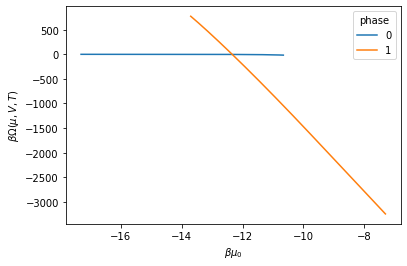

In [74]:
c.xgce_prop.betaOmega().swap_dims({'rec':'lnz_0'}).plot(hue='phase')

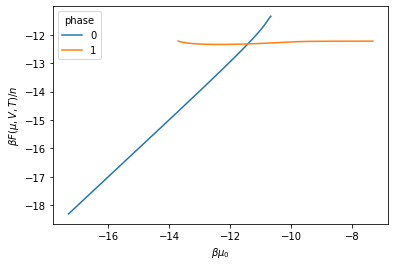

In [59]:
c.xgce_prop.betaF_n().swap_dims({'rec':'lnz_0'}).plot(hue='phase')

In [60]:
spin, _ = c.spinodals(2, build_phases=build_phases, as_dict=False)
bino, _ = c.binodals(2, spinodals=spin, build_phases=build_phases, as_dict=False)

In [61]:
c.xgce_prop.table(['betamu'])

<xarray.Dataset>
Dimensions:  (component: 1, phase: 2, rec: 1000)
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -17.31 -17.3 -17.29 -17.28 ... -7.329 -7.319 -7.309
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Dimensions without coordinates: component
Data variables:
    betamu   (rec, phase, component) float64 -17.31 nan -17.3 ... nan -7.309
    nvec     (rec, phase, component) float64 0.01666 nan 0.01683 ... nan 659.9
    betapV   (rec, phase) float64 0.01666 nan 0.01683 ... nan 3.245e+03
    PE_n     (rec, phase) float64 -0.0002614 nan -0.0002641 ... nan -6.045

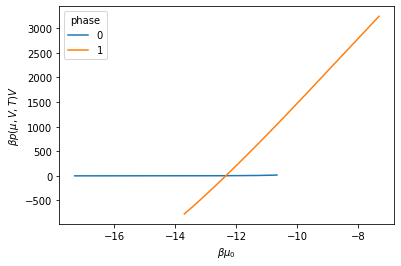

In [62]:
c.xgce_prop.betapV().swap_dims({'rec':'lnz_0'}).plot(hue='phase')

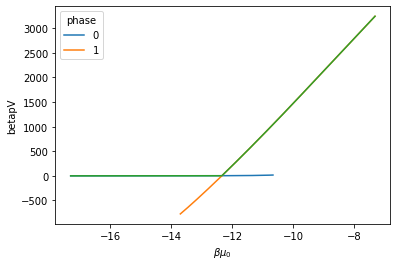

In [63]:
c.xgce_prop.table(dim_to_suffix='component', mask_stable=False).swap_dims({'rec':'lnz_0'}).betapV.plot(hue='phase')
c.xgce_prop.table(dim_to_suffix='component', mask_stable=True).swap_dims({'rec':'lnz_0'}).betapV.plot(hue='phase')

In [64]:
spin

<CollectionPhases  (rec : 2)>
index Int64Index([0, 1], dtype='int64', name='rec')

In [65]:
spin.xgce_prop.table(['mask_stable']).rename({'rec':'spin'})#.pipe(lambda x: x.where(~x.mask_stable))

<xarray.Dataset>
Dimensions:      (component: 1, phase: 2, spin: 2)
Coordinates:
    lnz_0        (spin) float64 -10.67 -13.7
    volume       (spin) int64 729 729
    temp         (spin) float64 0.7 0.7
    beta         (spin) float64 1.429 1.429
  * spin         (spin) int64 0 1
  * phase        (phase) int64 0 1
Dimensions without coordinates: component
Data variables:
    mask_stable  (spin, phase) bool False True True False
    nvec         (spin, phase, component) float64 23.57 640.4 0.6261 523.7
    betapV       (spin, phase) float64 16.3 1.039e+03 0.6212 -770.3
    PE_n         (spin, phase) float64 -0.4755 -5.912 -0.009935 -4.92

In [66]:
(
    spin.xgce_prop
    .betaOmega()
    .pipe(lambda x: x.where(x.phase == x.rec))
#     .table(['mask_stable']).pipe(lambda x: x.where(~x.mask_stable, drop=True))
#     .swap_dims({'rec':'lnz'})
)


<xarray.DataArray 'betaOmega' (rec: 2, phase: 2)>
array([[-16.299163,        nan],
       [       nan, 770.339413]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -10.67 -13.7
    volume   (rec) int64 729 729
    temp     (rec) float64 0.7 0.7
    beta     (rec) float64 1.429 1.429
  * rec      (rec) int64 0 1
Attributes:
    dims_n:         ['n_0']
    dims_lnz:       ['lnz_0']
    dims_comp:      ['component']
    dims_state:     ['lnz_0', 'volume', 'temp', 'beta']
    standard_name:  grand_potential
    long_name:      $\beta \Omega(\mu,V,T)$

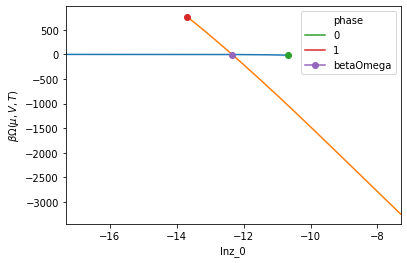

In [67]:
c.xgce.betaOmega().swap_dims({'rec':'lnz_0'}).plot(hue='phase')

(
    spin.xgce.betaOmega()
    .pipe(lambda x: x.where(x.phase == x.rec))
    .swap_dims({'rec':'lnz_0'})
    .plot(hue='phase', marker='o')
)

bino.xgce_prop.betaOmega().sel(phase=0).to_dataframe().plot('lnz_0','betaOmega', marker='o', ax=plt.gca())

In [70]:
# mu min/max

In [11]:
p_min, r = lnPi.monoutils.get_lnz_min(0.0001, c, build_phases)

p_max, r = lnPi.monoutils.get_lnz_max(8, ref=ref, threshold_abs=1e-4, C=c, build_phases=build_phases)

In [27]:
c = lnPi.CollectionPhases.from_builder(np.linspace(p_min.lnz[0], p_max.lnz[0], 200), build_phases=build_phases)

In [26]:
c = lnPi.CollectionPhases.from_lnz([None], np.linspace(p_min.lnz[0], p_max.lnz[0], 200), 
                                  build_phases=PhaseCreator.build_phases)

In [29]:
c.spinodals(2, build_phases=build_phases, append=True, inplace=True, build_kws=dict(efac=0.5))
c.binodals(2, build_phases=build_phases, append=True, inplace=True, build_kws=dict(efac=0.5
                                                                                  ))

In [ ]:
# spin, _ = c.spinodals([0,1], build_phases=PhaseCreator.build_phases, build_kws=dict(efac=0.5))
# bino,_ = c.binodals([0,1], spinodals=spin, build_phases=PhaseCreator.build_phases, build_kws=dict(efac=0.5))

In [31]:
c.sort_by_lnz()

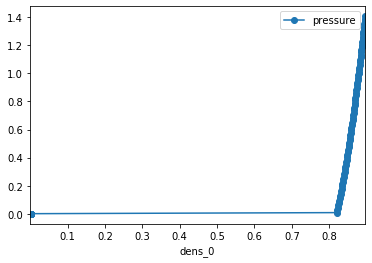

In [32]:
table = c.xgce_prop.table(['dens','pressure'], mask_stable=True, dim_to_suffix='component')
table.to_dataframe().plot('dens_0','pressure', marker='o')

In [33]:
import xarray as xr
@xr.register_dataarray_accessor('lwhere')
def lwhere(da):
    def where(condition, drop=False):
        return da.where(condition(da), drop=drop)
    return where

In [34]:
# test saving

In [35]:
da = (
    c.to_dataarray()
    .pipe(c.spinodals.assign_coords)
    .pipe(c.binodals.assign_coords)
    .sortby('lnz_0')
    .reset_index('rec', drop=True)
)

In [36]:
c2 = lnPi.CollectionPhases.from_dataarray(ref, da)
c2.spinodals.from_dataarray(da)
c2.binodals.from_dataarray(da)

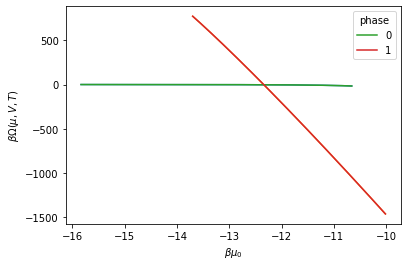

In [37]:
c.xgce.betaOmega().swap_dims({'rec':'lnz_0'}).plot(hue='phase')
c2.xgce.betaOmega().swap_dims({'rec':'lnz_0'}).plot(hue='phase')

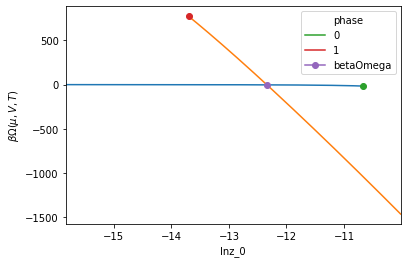

In [38]:
c.xgce.betaOmega().swap_dims({'rec':'lnz_0'}).plot(hue='phase')

(
    c.spinodals.access.xgce.betaOmega()
    .pipe(lambda x: x.where(x.phase == x.rec))
    .swap_dims({'rec':'lnz_0'})
    .plot(hue='phase', marker='o')
)

c.binodals.access.xgce_prop.betaOmega().sel(phase=0).to_dataframe().plot('lnz_0','betaOmega', marker='o', ax=plt.gca())

In [39]:
c.binodals.access.xgce.betaOmega().pipe(lambda x: x / x['beta']).assign_coords(mu_0=lambda x: x['lnz_0'] / x['beta'])

<xarray.DataArray (rec: 1, phase: 2)>
array([[-1.732533, -1.732533]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -12.34
    volume   (rec) int64 729
    temp     (rec) float64 0.7
    beta     (rec) float64 1.429
  * rec      (rec) int64 0
    mu_0     (rec) float64 -8.637

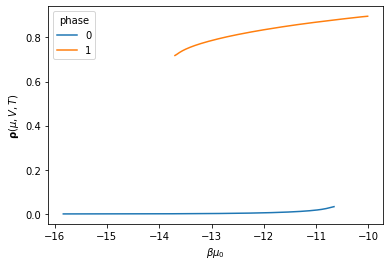

In [46]:
c.xgce_prop.dens.swap_dims({'rec':'lnz_0'}).squeeze().plot(hue='phase')

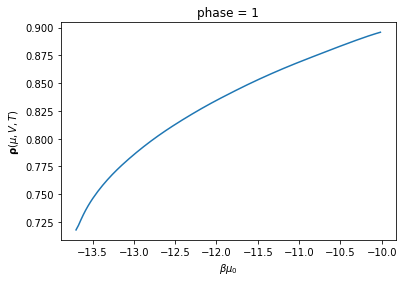

In [57]:
c.xgce_prop.dens.swap_dims({'rec':'lnz_0'}).sel(phase=1).plot()

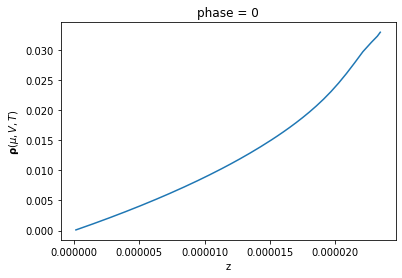

In [61]:
c.xgce_prop.dens.assign_coords(z=lambda x: np.exp(x.lnz_0)).swap_dims({'rec':'z'}).squeeze().sel(phase=0).plot(hue='phase')

# bulk 065

In [149]:
xx = c[0:10].xgce_prop.betapV()

$$ \ln z $$

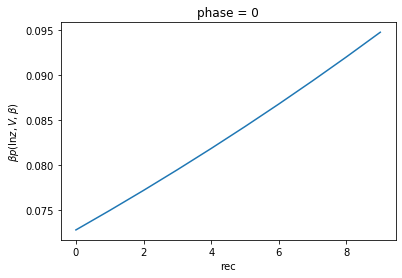

In [154]:
xx.assign_attrs(long_name=r'$\beta p(\lnz, V, \beta)$').plot()

Text(0.5, 0, '$\\beta{\\bf \\mu}$')

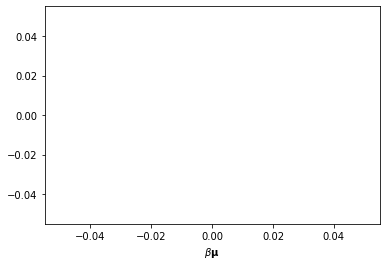

In [138]:
plt.plot([0],[0])
plt.xlabel(r'$\beta{\bf \mu}$')

In [134]:
dens

<xarray.DataArray 'dens' (rec: 203, phase: 2, component: 1)>
array([[[1.000000e-04],
        [         nan]],

       [[1.029724e-04],
        [         nan]],

       ...,

       [[         nan],
        [8.951050e-01]],

       [[         nan],
        [8.957373e-01]]])
Coordinates:
  * phase    (phase) int64 0 1
    lnz_0    (rec) float64 -15.83 -15.8 -15.78 -15.75 ... -10.07 -10.05 -10.02
    volume   (rec) int64 729 729 729 729 729 729 729 ... 729 729 729 729 729 729
    temp     (rec) float64 0.7 0.7 0.7 0.7 0.7 0.7 ... 0.7 0.7 0.7 0.7 0.7 0.7
    beta     (rec) float64 1.429 1.429 1.429 1.429 ... 1.429 1.429 1.429 1.429
  * rec      (rec) int64 0 1 2 3 4 5 6 7 8 ... 195 196 197 198 199 200 201 202
Dimensions without coordinates: component
Attributes:
    long_name:  density(component,lnz,V,beta)

In [21]:
base_bulk = lnPi.MaskedlnPi.from_table('./PiofN/ljcut.t065.bulk.v1000.r1.lnpi.dat', mu=-4.453015418106743E+00,
                               state_kws=dict(volume=1000.0E0,beta=1./0.65000E0))

builder_bulk = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=base_bulk, merge_kws=dict(efac=0.5), tag_phases=tag_phases2)

In [23]:
# initial estimate
c_bulk = lnPi.CollectionPhases.from_mu([None], np.linspace(ref.mu[0] - 4, ref.mu[0] + 4, 20), build_phases=builder_bulk.build_phases)
# c_bulk.spinodals(phase_ids=2, build_phases=builder_bulk.build_phases, build_kws=dict(efac=0.5), append=True)
# c_bulk.binodals(phase_ids=2, spinodals=spin, build_phases=builder_bulk.build_phases, build_kws=dict(efac=0.5), append=True)
# c_bulk.sort_by_mu()

# min/max
p_min, r = lnPi.monoutils.get_mu_min(0.0001, [None], c, PhaseCreator.build_phases)
p_max, r = lnPi.monoutils.get_mu_max(10, ref=base_bulk, build_phases=PhaseCreator.build_phases)


# better
c_bulk = lnPi.CollectionPhases.from_mu([None], np.linspace(p_min.mu[0], p_max.mu[0], 200), build_phases=builder_bulk.build_phases)
c_bulk.spinodals(phase_ids=2, build_phases=builder_bulk.build_phases, build_kws=dict(efac=0.5), append=True)
c_bulk.binodals(phase_ids=2, build_phases=builder_bulk.build_phases, build_kws=dict(efac=0.5), append=True)
c_bulk.sort_by_mu()



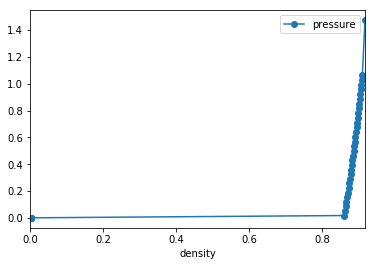

In [24]:
dens = c_bulk.xgce.density
pres = c_bulk.xgce.pressure()

# mask values
mask = pres.pipe(lambda x: x.max('phase') == x)

df = (
    xr.merge((dens, pres))
    .where(mask).max('phase')
    .to_dataframe()
)
    

df.plot('density','pressure',marker='o')

In [25]:
### p.assign_coords(n_0=p.n_0.assign_attrs(long_name='hello'))

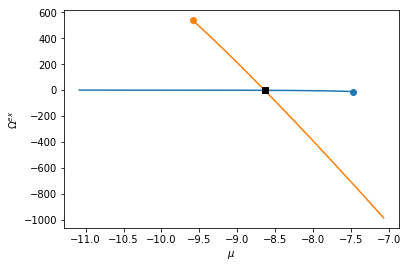

In [26]:
make_omega_vs_mu_phase_plot(c)

# confined

In [27]:
base_conf = lnPi.MaskedlnPi.from_table('./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.lnpi.dat',mu=-0.500000E+01,state_kws=dict(volume=7000.,beta=1./0.65000E0))


phasecreator_conf = lnPi.segment.PhaseCreator(nmax=2, nmax_peak=4, ref=base_conf, merge_kws=dict(efac=0.6), tag_phases=tag_phases2)

build_phases_conf = phasecreator_conf.build_phases





In [94]:
# initial estimate
c_conf = lnPi.CollectionPhases.from_mu([None], np.linspace(base_conf.mu[0] - 5, base_conf.mu[0] + 5, 20), 
                                       build_phases=build_phases_conf, build_phases_kws=(dict(efac=1.0, merge_phase_ids=True)))

# min/max
p_min, r = lnPi.monoutils.get_mu_min(0.0001, [None], c_conf, build_phases_conf)
p_max, r = lnPi.monoutils.get_mu_max(10, ref=base_conf, build_phases=build_phases_conf)

# better estimate
c_conf = lnPi.CollectionPhases.from_mu([None], np.linspace(p_min.mu[0], p_max.mu[0], 200), 
                                       build_phases=build_phases_conf, build_phases_kws=(dict(efac=1.0, merge_phase_ids=True)))




In [95]:
c_conf.spinodals(phase_ids=2, build_phases=build_phases_conf, build_kws=dict(efac=0.5), append=True)
c_conf.binodals(phase_ids=2, build_phases=build_phases_conf, build_kws=dict(efac=0.5), append=True)
c_conf.sort_by_mu()

(-5.14, -5.09)

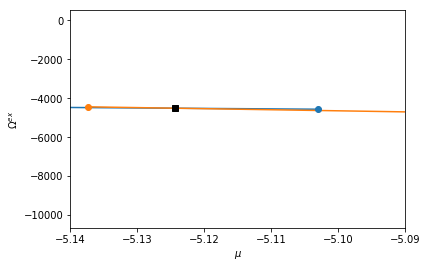

In [96]:
make_omega_vs_mu_phase_plot(c_conf)
plt.xlim(-5.14,-5.09)

In [100]:
df=pd.read_table('./PiofN/ljcut.t065.finiteslit.L_20nm.W_4nm.r2.single_isotherm.txt',sep='\s+',
                 header=None,names=['pscaled','mu','rho','Omega_L','Qst','Gads'])


/Users/wpk/.conda/envs/py37/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: read_table is deprecated, use read_csv instead.
  


# make isotherm

In [101]:
a = np.log(np.linspace(np.exp(-10), np.exp(c_conf.spinodals[1].mu[0]), 50, endpoint=False))

In [110]:
#a = np.linspace(-10,Cconf.spinodals[1].mu[0],200)
b = np.linspace(c_conf.spinodals[1].mu[0],c_conf.spinodals[0].mu[0],50)
c = np.linspace(c_conf.spinodals[0].mu[0],c_bulk.binodals[0].mu[0],50)
mus = np.concatenate((a,b,c))
#mus = c

In [111]:
print(c_conf.mu.max())
print(c_bulk.mu.max())

print(mus.max())

-4.178466796875
-2.8081126966781706
-4.453725936551545


In [112]:
cb = lnPi.core.CollectionPhases.from_mu([None],x=mus, ref=base_bulk, build_phases=builder_bulk.build_phases)
cc = lnPi.core.CollectionPhases.from_mu_iter(cb.mu, ref=base_conf, build_phases=build_phases_conf)

In [118]:
psat = c_bulk.binodals[0].xgce.pressure().sel(phase=0).values

In [119]:
p = cb.xgce.pressure().sel(phase=0) / psat

In [123]:
rho = cc.xgce.nave

In [141]:
iso = xr.merge((p.drop('volume'), rho.drop('volume'))).squeeze().to_dataframe().reset_index()

In [142]:
iso.head()

,phase,rec,mu_0,beta,pressure,nave
0,0,0,-10.000000,1.538462,0.000195,52.806189
1,0,1,-8.728236,1.538462,0.001377,774.982645
2,0,2,-8.186107,1.538462,0.003171,897.867008
3,0,3,-7.836514,1.538462,0.005430,941.621343
4,0,4,-7.577984,1.538462,0.008082,967.917146


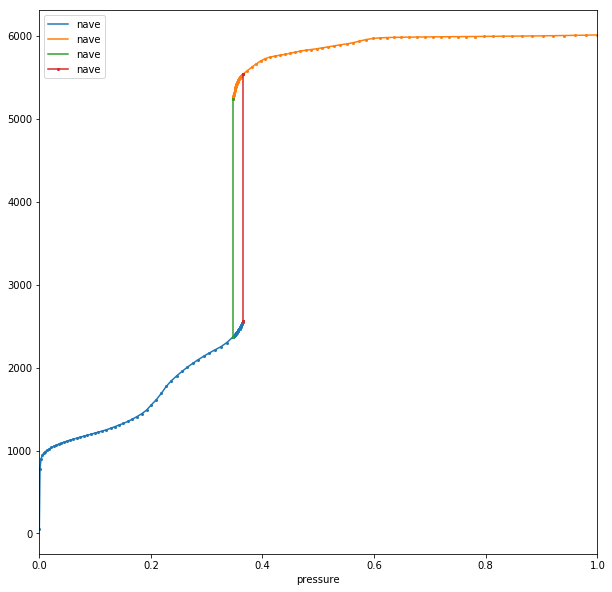

In [148]:
fig,ax = plt.subplots(figsize=(10,10))
for phase, g in iso.groupby('phase'):
    g.plot('pressure','nave', ax=ax,marker='o', ms=2)

iso.query('mu_0==@b[0]').drop_duplicates().plot('pressure','nave', ax=ax, marker='o', ms=2)
iso.query('mu_0==@b[-1]').drop_duplicates().plot('pressure','nave', ax=ax, marker='o', ms=2)

#plt.plot(df.pscaled,df.rho,'--', marker='o', ms=2)
# plt.gca().set_xlim(0,1.0)

(0.3, 0.5)

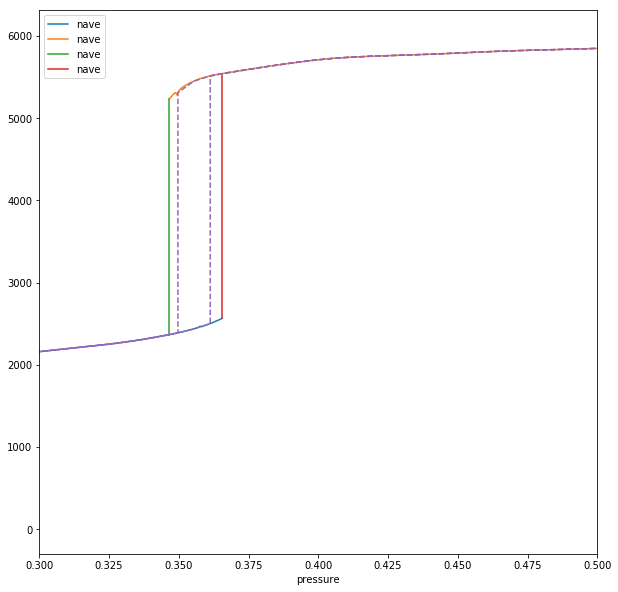

In [146]:
fig,ax = plt.subplots(figsize=(10,10))
for phase, g in iso.groupby('phase'):
    g.plot('pressure','nave', ax=ax)

iso.query('mu_0==@b[0]').drop_duplicates().plot('pressure','nave', ax=ax)
iso.query('mu_0==@b[-1]').drop_duplicates().plot('pressure','nave', ax=ax)

plt.plot(df.pscaled,df.rho,'--')
plt.gca().set_xlim(0.3,0.5)



In [74]:
# hard one